<div style="text-align: center;">
    <a href="https://www.hi-paris.fr/">
        <img border="0" src="https://www.hi-paris.fr/wp-content/uploads/2020/09/logo-hi-paris-retina.png" width="25%"></a>
    <a href="https://www.dataia.eu/">
        <img border="0" src="https://github.com/ramp-kits/template-kit/raw/main/img/DATAIA-h.png" width="70%"></a>
</div>

# DPE Label Prediction Challenge — Starting Kit

<i> Datacamp 2025 — Codabench Challenge </i>

<i> ANZALA Pierre, BABAK Matthieu, DOCQ Mayeul, LARRY Alexandre <i>

![Carte des régions](pages/DPE_categories.png)

## Introduction

### Problem statement
Since 2006, the DPE score (Diagnostic de Performance Énergétique) was introduced as an evaluation of the energy consumption and the emission of greenhouse gas for any building or house. This score ranks the latter from A (most efficient) to G (least efficient) and is valid for 10 years. It is established based on official criteria such as heating and cooling capabilities, ventilation, etc.s

In 2021, establishing the DPE score became mandatory for every sale or letting of an apartment/house with certain properties behing forbidden from sale because of low DPE scores. In 2025 furthermore, the French government decided that most DPE scores were to be recalculated in accordance with new guidelines.

DPE scores are thus essential for property management but can only be delivered by certain certified entities. Hence, being able to anticipate such a rating proves to be valuable in anticipation of any sale/letting. It can also guide renovations to boost preparedness for future legislation.

**Sources :** 
- https://www.ecologie.gouv.fr/politiques-publiques/diagnostic-performance-energetique-dpe#:~:text=Sauf%20exception%2C%20la%20r%C3%A9alisation%20d,apr%C3%A8s%20le%201er%20juillet%202007
- https://www.service-public.gouv.fr/particuliers/vosdroits/F16096 
- https://www.ecologie.gouv.fr/sites/default/files/falc/DPE_FALC.pdf 


### Data origin
DPE data is centralized by the ADEME agency (Agence de l'Environnement et de la Maîtrise de l'Énergie) and has been published for existing housing in a publicly available dataset. The dataset is composed of many columns detailing all aspects of a property and is updated weekly. 

For this task, participants will focus on **data from 2025** as it was the year most DPEs were to be recalculated thus providing a full and descriptive dataset. The data is filtered to focus on the following : 
- Apartments only,
- DPEs have to be calculated using DPE version 2.4 criteria,
- DPEs have to be have been established in 2025 and not modified since.
- Data is only selected for metropolitain France.

# Exploratory data analysis

The provided dataset is very descriptive and contains 129 columns mixing both numerical and categorical data. In this section, we provide a few guidelines for data exploration and we explain the reasoning behind the train/test split for the challenge.

In [1]:
#IMPORT LIBRAIRIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import geopandas as gpd
import math

In [4]:
#IMPORT DATA
from ingestion_program.ingestion import get_train_data
X_df, y = get_train_data("dev_phase/input_data")

## DPE distribution

First, we need to know how the data is distributed in terms of DPEs : are more efficient properties the most represented ? In the dataset, we can see that average scores are the most represented.

In [9]:
#DPE DISTRIBUTION
repart_dpe = pd.Series(y).value_counts(normalize=True) * 100
dpe_colors = {"A": "#00A651",  "B": "#4CCB00","C": "#A8E600","D": "#FFD500","E": "#FF9C00","F": "#FF4E00","G": "#D80000"  }
colors = [dpe_colors[label] for label in repart_dpe.index]

labels_order = sorted(repart_dpe.keys())
repart_dpe= {k: repart_dpe.get(k, 0) for k in labels_order}

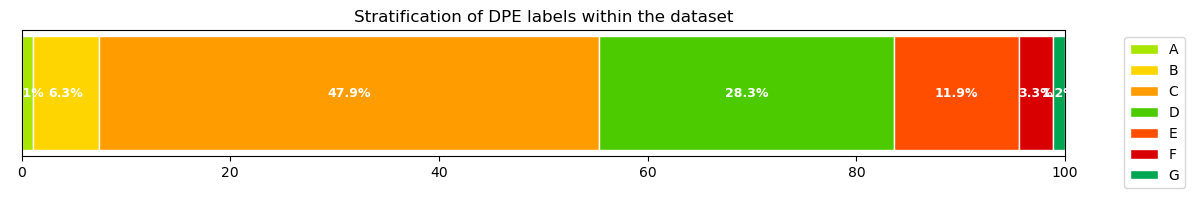

In [33]:
left = 0
plt.figure(figsize=(12,2))
for i, (etiquette, percent) in enumerate(repart_dpe.items()):
    plt.barh(0, percent, left=left, color=colors[i % len(colors)], edgecolor='white', label=etiquette)
    plt.text(left + percent / 2, 0, f"{percent:.1f}%", ha="center", va="center", fontsize=9, color="white", weight="bold")
    left += percent
plt.xlim(0, 100)
plt.yticks([])
plt.title("Stratification of DPE labels within the dataset")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

As shown by the visualization, almost 50% of apartments in the dataset fall in the "C" DPE category ie the lower tier of energetically efficient households.

## Visualization by region

It can also be interesting to look at how the data is partitioned geographically. As we only focus on apartments in this dataset, one can assume that most of the data will be concentrated around the Paris region, which the following visualisation corroborates.

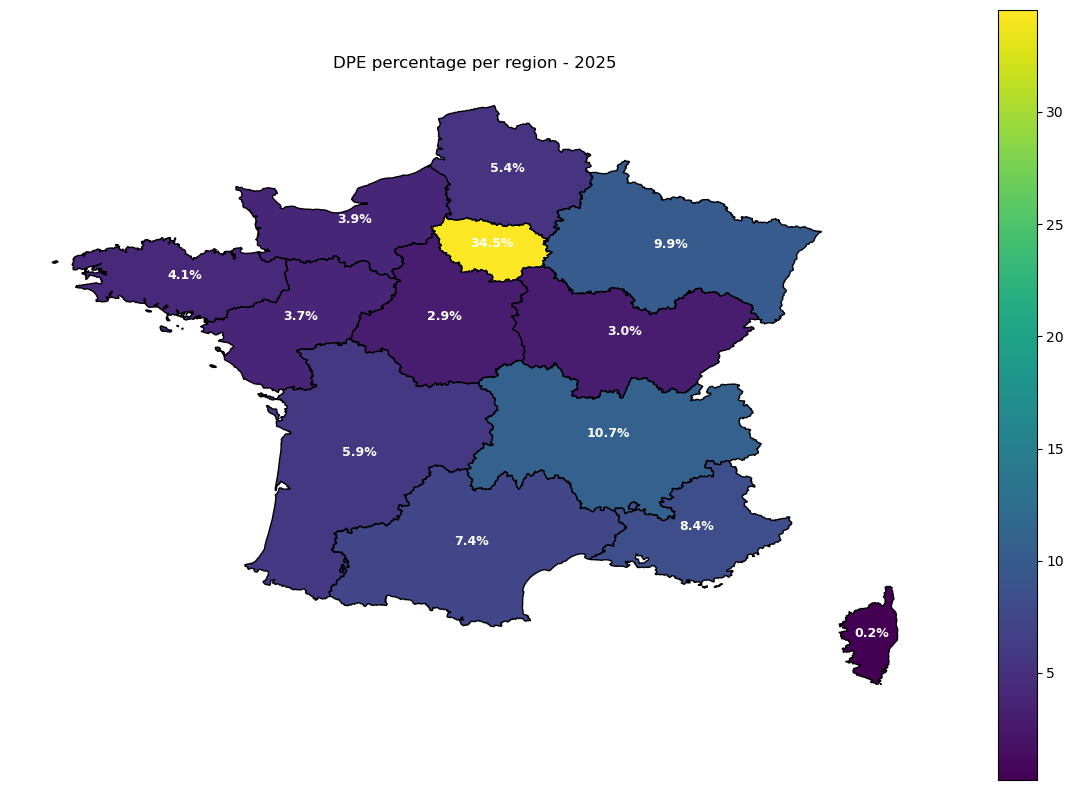

In [11]:
#REGION VISUALISATION
repart_region = X_df["code_region_ban"].value_counts(normalize=True)*100

geograph_data = gpd.read_file('pages/regions.geojson')
repart_region_df = repart_region.reset_index()
repart_region_df.columns = ["code", "percent"]

geograph_data['code'] = geograph_data['code'].astype(str)
repart_region_df['code'] = repart_region_df['code'].astype(str)

geograph_data_final = geograph_data.merge(repart_region_df, left_on="code", right_on="code", how="left")
gdf = gpd.GeoDataFrame(geograph_data_final)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='percent', legend=True, cmap='viridis', edgecolor='black', ax=ax)

for idx, row in gdf.iterrows():
    if pd.notnull(row['percent']):
        plt.annotate(
            text=f"{row['percent']:.1f}%",
            xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
            ha='center',
            fontsize=9,
            color='white',
            weight='bold'
        )

ax.set_axis_off()
plt.title("DPE percentage per region - 2025")
plt.show()

## VISUALIZATION BY DEPARTMENT
Finally, we can go a step further in granularity.

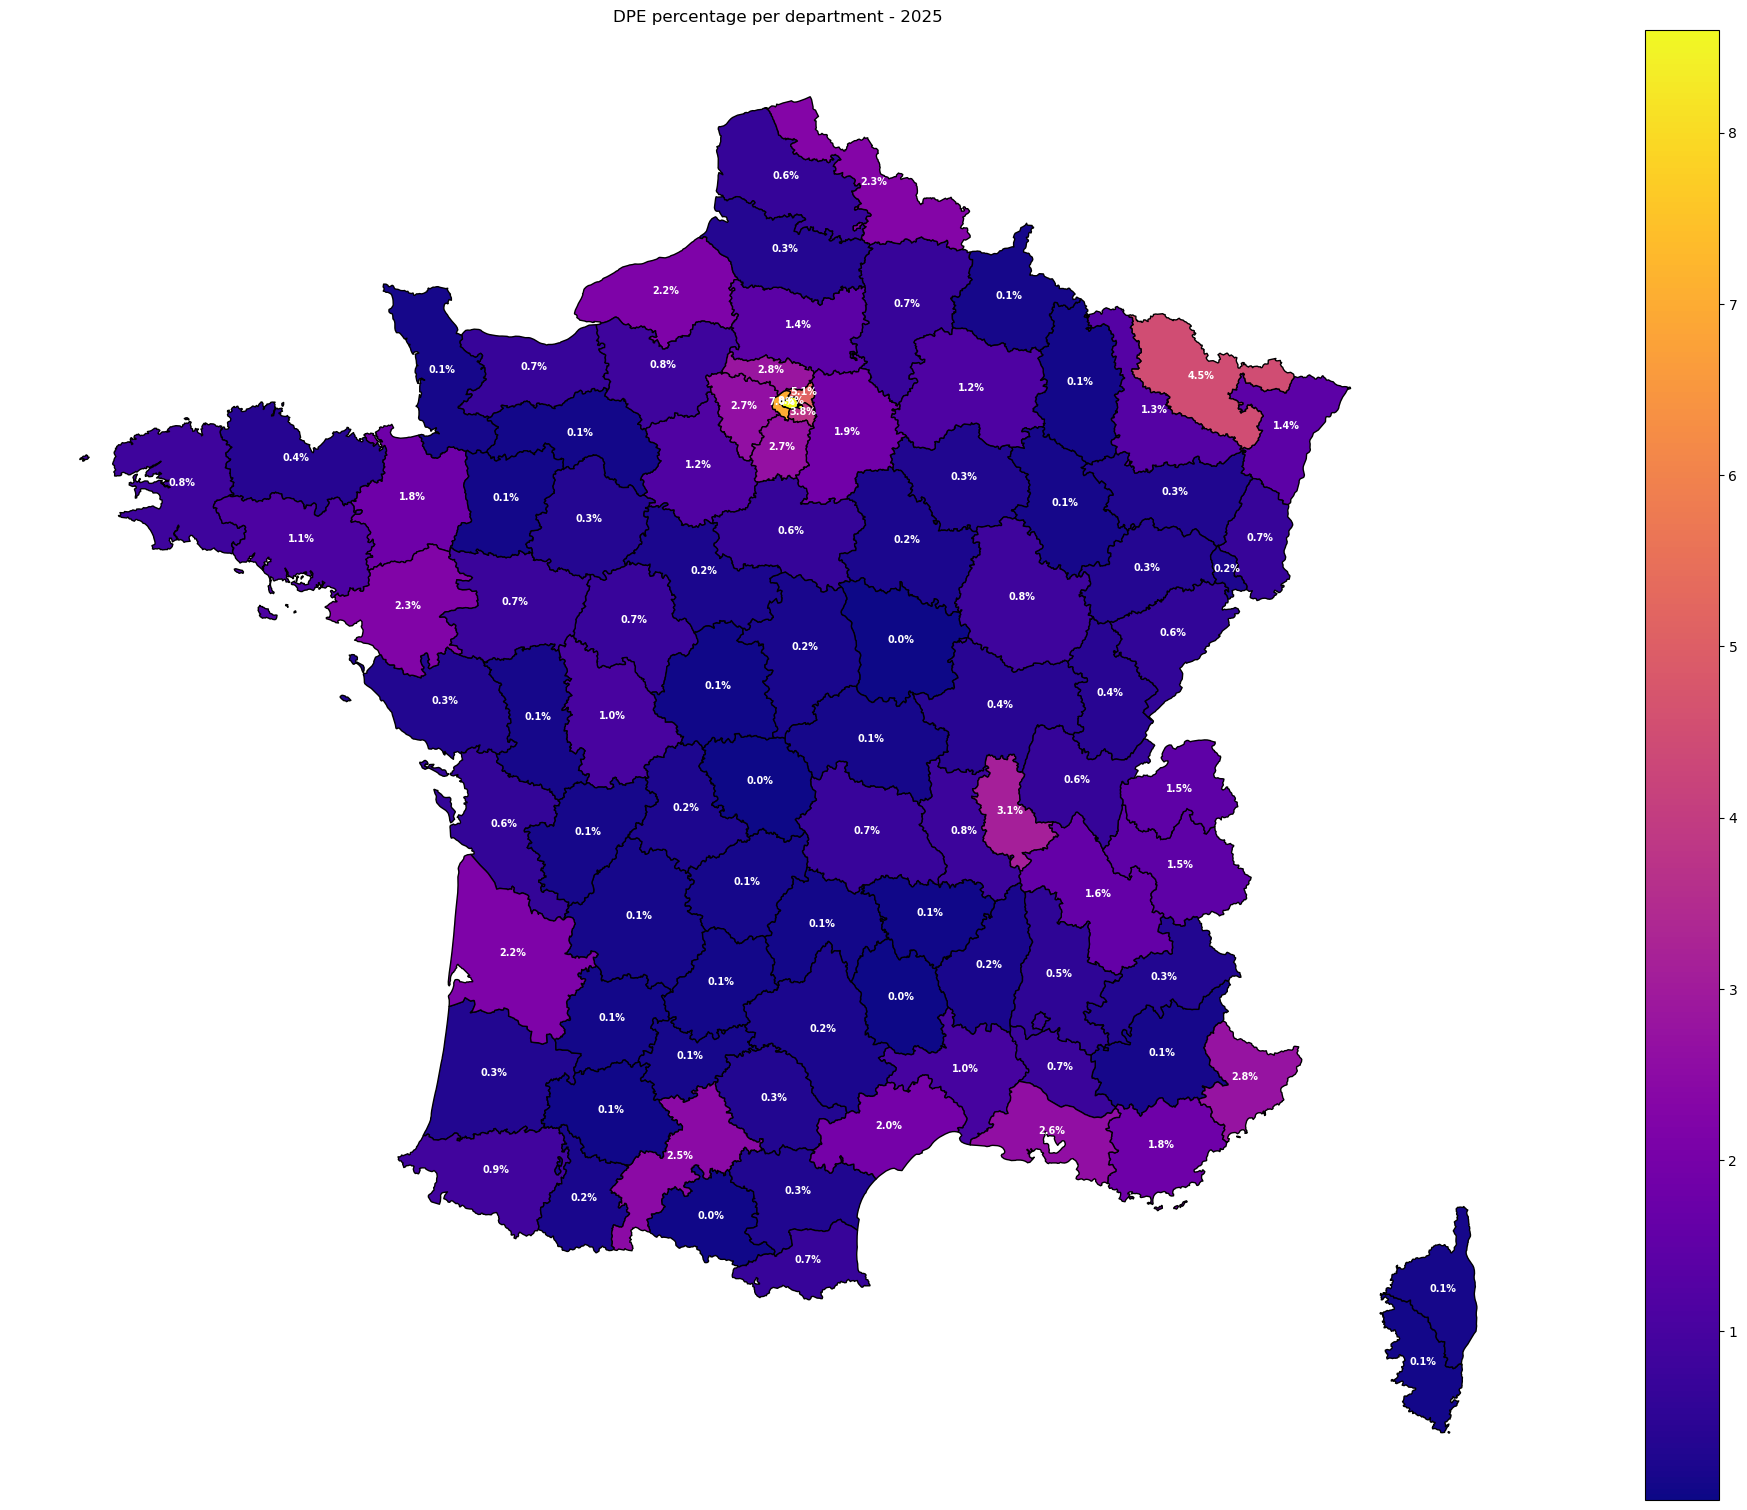

In [29]:
repart_depart = X_df["code_departement_ban"].value_counts(normalize=True)*100

geograph_data_depart = gpd.read_file('pages/departements.geojson')
geograph_data_depart = geograph_data_depart[~geograph_data_depart["code"].str.startswith("97")] #We exclude DOMTOM data
repart_depart_df = repart_depart.reset_index()
repart_depart_df.columns = ["code", "percent"]

geograph_data_depart['code'] = geograph_data_depart['code'].astype(str)
repart_depart_df['code'] = repart_depart_df['code'].astype(str)

geograph_data_final_depart = geograph_data_depart.merge(repart_depart_df, left_on="code", right_on="code", how="left")
gdf = gpd.GeoDataFrame(geograph_data_final_depart)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf.plot(column='percent', legend=True, cmap='plasma', edgecolor='black', ax=ax)
for idx, row in gdf.iterrows():
    if not pd.isna(row["percent"]):
        plt.text(
            row["geometry"].centroid.x,
            row["geometry"].centroid.y,
            f"{row['percent']:.1f}%",
            ha="center",
            fontsize=7,
            color='white',
            weight='bold'
        )
ax.set_axis_off()
plt.tight_layout()
plt.title("DPE percentage per department - 2025")
plt.show()

## Focus on numerical data

As previously stated, the dataset contains a lot of data which we has been previously filtered for clarity but can be further clarified. One statergy you can use is to focus on the numerical data and its correlation matrix.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


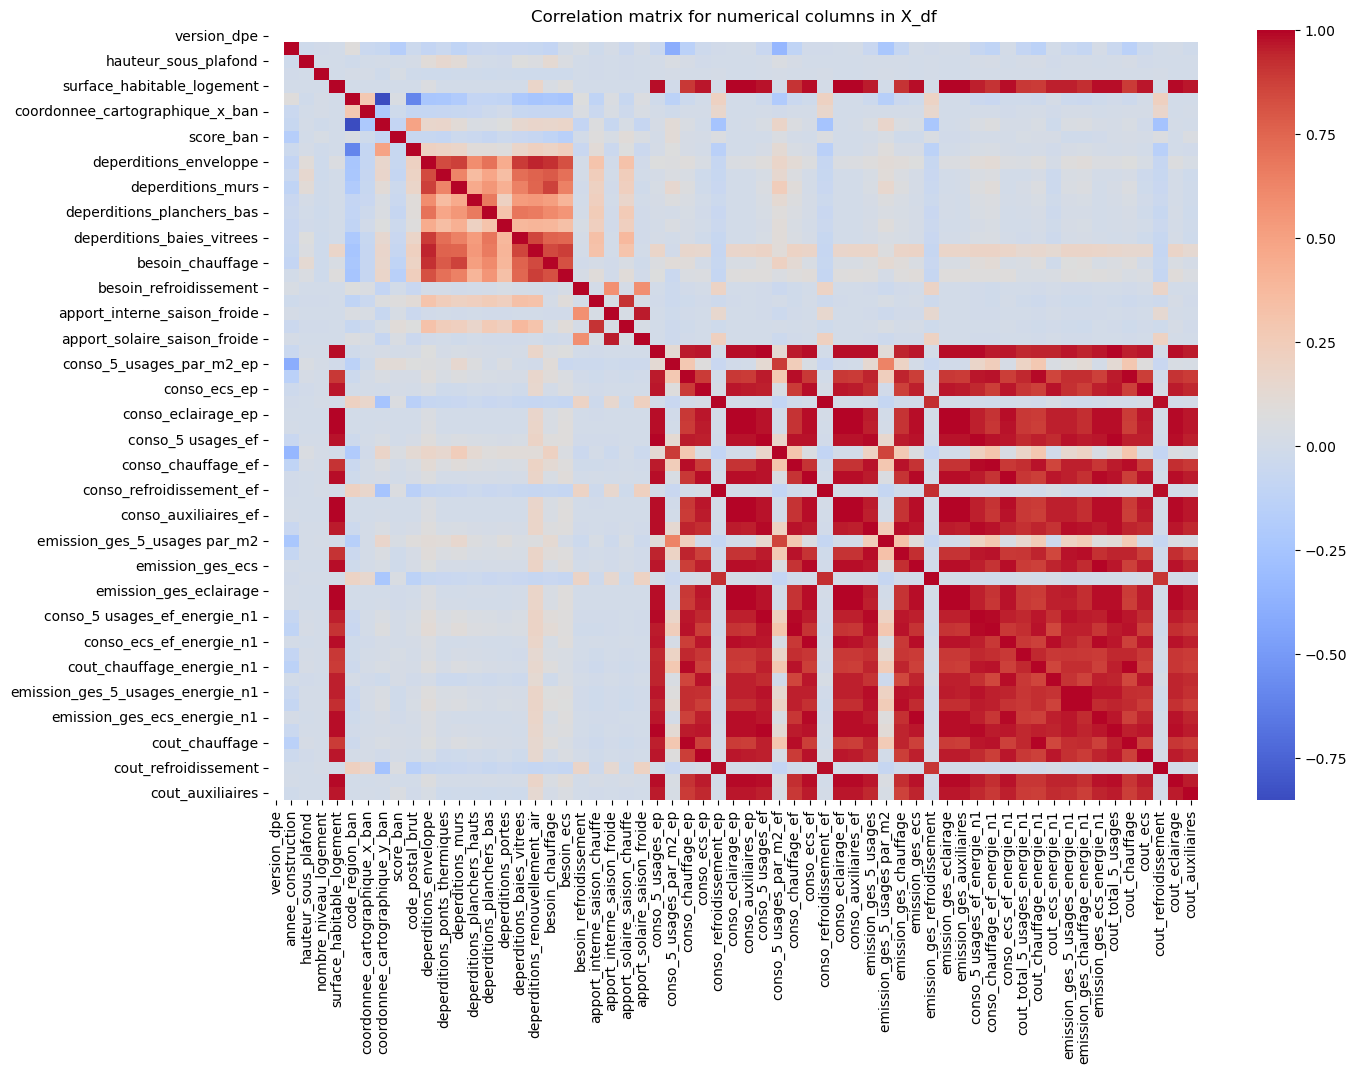

In [34]:
X_df_num = X_df.select_dtypes(include=['number'])

corr_matrix = X_df_num.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix for numerical columns in X_df")
plt.show()

# Challenge evaluation

As the aim of this challenge is to predict DPE scores for apartments throughout France, we need to develop a scoring metric to takes into account our categorical grades but also be inclined towards pessimistic models. Professionals would indeed prefer a model that is too pessimistic and delivers a below-relatity rating than the reverse as this could have substantial financial costs.

Your submissions will be evaluated using the **QWK (Quadratic Weighted Kappa)** metric. This metric is in range [-1,1] with the following interpretation : 
- -1 : complete disagreement between predictions and reality,
- 1 : complete agreement between predictions and reality,
- 0 : random agreement (i.e your model does not outperform a random model).

The calculation is then based on the outcome of three matrices : 
- O : the **confusion matrix** between actual and predicted labels,
- E : the **expected matrix** assuming random predictions following the actual label distribution,
- W : the **weight matrix** based on the ordinal distance between actual and predicted labels (this allows us to penalize an A-to-E wrong prediction more than a C-to-D e.g.). Here, each label is mapped to an index based on its order (A is 0, B is 1, C is 2, D is 3...).
$$ w_{i,j} = \frac{(i - j)^2}{(N-1)^2} $$

These three matrices are then combined in the following calculation : 
$$ \kappa = 1 - \frac{\sum_{i,j} w_{i,j} O_{i,j}}{\sum_{i,j} w_{i,j} E_{i,j}} $$

**Sources :**
- https://www.kaggle.com/c/data-science-bowl-2019/overview/evaluation 
- https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa 

# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the codabench platform.

## The submission file

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [2]:
# %load solution/submission.py
from sklearn.ensemble import RandomForestClassifier


# The submission here should simply be a function that returns a model
# compatible with scikit-learn API
def get_model():
    return RandomForestClassifier()


## Local testing pipeline

Here you can show how the model will be used to generate predictions on the test set, and how the evaluation will be performed.

In [3]:
model = get_model()
X_train, y_train = get_train_data("dev_phase/input_data")
model.fit(X_train, y_train)

X_test = pd.read_csv("dev_phase/input_data/test/test_features.csv")
from ingestion_program.ingestion import evaluate_model
y_test = evaluate_model(model, X_test)

from scoring_program.scoring import compute_accuracy
print("Accuracy on test set:", compute_accuracy(y_test, pd.read_csv("dev_phase/input_data/test/test_labels.csv")))

Accuracy on test set: 0.95


/home/tom/.local/miniconda/lib/python3.12/site-packages/sklearn/base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Submission

To submit your code, you can refer to the actual challenge.